### 3. Генерация признаков

Для строений города сгенерированы признаки в радиусе 100/200/300/500 метров от каждой точки:
- численность населения в шаговой доступности

Для исследуемых Points of Interest сгенерированы признаки в радиусе 100/200/300/500 метров от каждой точки:
- численность населения в шаговой доступности
- количество коммерческих объектов в шаговой доступности
- статистики расстояний до коммерческих объектов для каждой точки - mean, std
- расстояние до ближайшего объекта каждого вида точек (расст. до ближайшего магазина, до ближайшего банкомата и т.д.)

### WARNING

Расчеты данного блока занимают большое количество времени.

Рекомендуется производить их в Google Colab или используя сопоставимые мощности

In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
with open('./data/adm.geojson', 'r') as f:
    adm = json.load(f)
    
adm = pd.DataFrame(adm['features']).drop('type', axis = 1)
boundries = np.array(adm.geometry[0]['coordinates']).reshape(-1,2)

In [9]:
poi = pd.read_csv('_total_poi.csv')
bui = pd.read_csv('_buildings.csv')

In [10]:
poi.head()

,lat,long,amenity,name,description,operator,brand,brand:wikipedia
0,43.096901,131.867301,goverment,Vladivostok customs,Владивостокский таможенный пост,NaN,NaN,NaN
1,43.116883,131.879218,atm,NaN,NaN,МДМ Банк,NaN,NaN
2,43.133078,131.898725,culture,Москва,NaN,NaN,NaN,NaN
3,43.112159,131.873115,nightclub,Наутилус,NaN,NaN,NaN,NaN
4,43.112892,131.932432,education,NaN,NaN,NaN,NaN,NaN


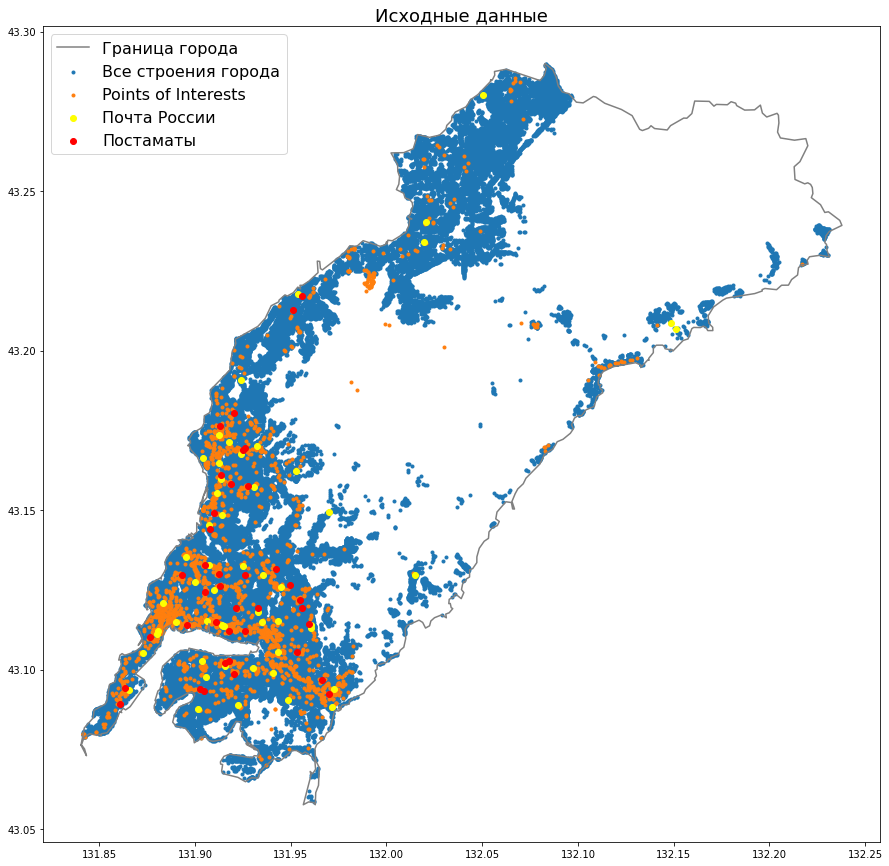

In [19]:
# Визуализируем исходные данные

points = poi[poi['amenity'] == 'post_office']
plt.figure(figsize = (15,15))

plt.plot(boundries[:,0], boundries[:,1], c='grey', label = 'Граница города')
plt.scatter(bui.long, bui.lat, marker = '.', label = 'Все строения города')
plt.scatter(poi.long, poi.lat, marker = '.', label = 'Points of Interests')
plt.scatter(points.long, points.lat, c='yellow', marker = 'o', label = 'Почта России')

points = poi[poi['amenity'] == 'postamat']
plt.scatter(points.long, points.lat, c='red', marker = 'o', label = 'Постаматы')

plt.title('Исходные данные', fontsize = 18)
plt.legend(fontsize = 16)
plt.show()

In [14]:
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

In [16]:
# функция расстояния между двумя точками от географичеcких координат

def dist(x, y):
    l1, l2 = np.radians(x[1]), np.radians(y[1])
    s1, s2 = np.radians(x[0]), np.radians(y[0])
    dl = np.abs(l1-l2)
    return np.arccos(np.sin(s1)*np.sin(s2)+np.cos(s1)*np.cos(s2)*np.cos(dl)) * 6372000

### Обучим модель, определяющую численность(плотность) населения в шаговой доступности
для 4х вариантов - 100м, 200м, 300м, 500м

- ищем строения в заданном радиусе
- определяем численность населения в окрестности исходного строения
- суммируем данные для заданного радиуса в каждой точке

In [17]:
%%time
# bui_neig - хранит оптимизированную базу всех домов Владивостока для поиска соседей в заданном радиусе

bui_neig = NearestNeighbors(radius=500, algorithm='ball_tree', metric = dist)
bui_neig.fit(bui[['lat', 'long']])

CPU times: user 1min 20s, sys: 538 ms, total: 1min 21s
Wall time: 1min 25s


NearestNeighbors(algorithm='ball_tree',
                 metric=<function dist at 0x7f8050423e50>, radius=500)

#### ПЛОТНОСТЬ НАСЕЛЕНИЯ В ШАГОВОЙ ДОСТУПНОСТИ для buildings (СЧИТАЕТСЯ В GOOGLE COLAB)

In [7]:
def population_density(points, i, radius = 500):
    point = points[['lat', 'long']].iloc[i]
    point_neig = bui_neig.radius_neighbors(point.values.reshape(-1,2), radius = radius)[1][0]
    return bui.population[point_neig].sum()

In [ ]:
density = {100: [], 200: [], 300: [], 500: []}

for radius in tqdm([100,200,300,500]):
    for i in tqdm(range(len(bui))):
        density[radius].append(population_density(bui, i, radius))

In [ ]:
for radius in tqdm([100,200,300,500]):
    bui['density{}'.format(radius)] = density[radius]

In [218]:
bui.head()

,amenity_place,floors,population,address,lat,long,density100,density200,density300,density500
0,marketplace,2.0,NaN,690037 улица Адмирала Юмашева 37А,43.125287,131.957594,0.0,290.0,1137.0,6833.0
1,marketplace,1.0,NaN,,43.125417,131.958202,0.0,192.0,717.0,4979.0
2,marketplace,3.0,NaN,улица Нейбута 125,43.123237,131.963757,0.0,0.0,355.0,1795.0
3,marketplace,1.0,NaN,,43.125295,131.957713,0.0,290.0,928.0,6833.0
4,marketplace,2.0,NaN,улица Сабанеева 22А,43.128502,131.956351,0.0,864.0,1056.0,3962.0


In [217]:
bui = pd.to_csv('_buildings_density.csv')

#### Плотность населения шаговой доступности для POI

In [20]:
density = {100: [], 200: [], 300: [], 500: []}

for radius in tqdm([100,200,300,500]):
    for i in tqdm(range(len(poi))):
        density[radius].append(population_density(poi, i, radius))

In [22]:
for radius in tqdm([100,200,300,500]):
    poi['density{}'.format(radius)] = density[radius]

## Метрические признаки (расстояния) Points if Interest

In [29]:
# выделим категории коммерческих объектов, влияние которых будем изучать и учитывать
# считаем их наиболее значимыми для оценки трафика, т.к. в основном данные виды точки стоят 
# в местах высокого трафика, в ином случае точка убыточна и закрывается - т.е. это корректируется рынком

amenities = 'atm cafe grocery pharmacy bank fast_food'.split()

In [30]:
# подвыборка коммерческих объектов Points of Interest

commersial = poi[poi.amenity.isin(amenities)]

In [247]:
commersial

,lat,long,amenity,name,description,operator,brand,brand:wikipedia,density100,density200,density300,density500
1,43.116883,131.879218,atm,NaN,NaN,МДМ Банк,NaN,NaN,241.0,1272.0,2802.0,5950.0
5,43.131709,131.912523,atm,Банкомат Росбанка,NaN,NaN,NaN,NaN,326.0,2382.0,5191.0,12488.0
7,43.133118,131.912551,atm,NaN,NaN,РосБанк,NaN,NaN,0.0,362.0,2728.0,9090.0
9,43.116214,131.881468,cafe,Studio Coffee,NaN,NaN,NaN,NaN,590.0,1388.0,2863.0,5414.0
10,43.118162,131.880029,cafe,Paparazzi,NaN,NaN,NaN,NaN,154.0,1003.0,1624.0,4696.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2410,43.169773,131.907796,grocery,Эл-Мир,Эл-Мир,NaN,мини-маркет,NaN,1674.0,4432.0,8354.0,14683.0
2411,43.083021,131.853045,grocery,Минимаркет,NaN,Минимаркет,NaN,NaN,1676.0,2477.0,2983.0,5237.0
2412,43.176588,131.917087,grocery,Моя мечта,Моя мечта,NaN,мини-маркет,NaN,391.0,2027.0,4777.0,13728.0
2413,43.178099,131.931135,grocery,Мини-маркет,NaN,Мини-маркет,NaN,NaN,1735.0,3560.0,3560.0,3571.0


### Обучим модели для поиска ближайших соседей в нужных категориях

In [248]:
%%time
# commersial_neig - соседи изучаемых коммерческих категорий

commersial_neig = NearestNeighbors(algorithm = 'ball_tree', metric = dist).fit(commersial[['lat', 'long']])

CPU times: user 852 ms, sys: 8.11 ms, total: 861 ms
Wall time: 911 ms


In [1]:
# статистики расстояний до коммерческих объектов в радиусе 100/200/300/500м

nearest_commerc_features = {}
nearest_commerc_features[100] = {'sum':[], 'mean': [], 'std':[]}
nearest_commerc_features[200] = {'sum':[], 'mean': [], 'std':[]}
nearest_commerc_features[300] = {'sum':[], 'mean': [], 'std':[]}
nearest_commerc_features[500] = {'sum':[], 'mean': [], 'std':[]}

commerc_radius = [100, 200, 300, 500]

for radius in tqdm(nearest_commerc_features):
    for i in tqdm(range(len(poi))):
        point = poi[['lat','long']].iloc[i]
        rng = commersial_neig.radius_neighbors(point.values.reshape(-1,2), radius = radius)

        # кол-во коммерческих объектов в радиусе radius от точки i
        nearest_commerc_features[radius]['sum'].append(len(rng[0][0]))
        
        # mean расстояний до коммерческих объектов в радиусе radius от точки i
        nearest_commerc_features[radius]['mean'].append(np.mean(rng[0][0]))
        
        # std расстояний до коммерческих объектов в радиусе radius от точки i
        nearest_commerc_features[radius]['std'].append(np.std(rng[0][0]))

In [294]:
poi['nearest_com_100_sum'] = nearest_commerc_features[100]['sum']
poi['nearest_com_100_mean'] = nearest_commerc_features[100]['mean']
poi['nearest_com_100_std'] = nearest_commerc_features[100]['std']

poi['nearest_com_200_sum'] = nearest_commerc_features[200]['sum']
poi['nearest_com_200_mean'] = nearest_commerc_features[200]['mean']
poi['nearest_com_200_std'] = nearest_commerc_features[200]['std']

poi['nearest_com_300_sum'] = nearest_commerc_features[300]['sum']
poi['nearest_com_300_mean'] = nearest_commerc_features[300]['mean']
poi['nearest_com_300_std'] = nearest_commerc_features[300]['std']

poi['nearest_com_500_sum'] = nearest_commerc_features[500]['sum']
poi['nearest_com_500_mean'] = nearest_commerc_features[500]['mean']
poi['nearest_com_500_std'] = nearest_commerc_features[500]['std']

In [249]:
%%time
# модели ближайших соседей до отдельным изучаемым категориям
ds = poi

facility_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'facility'][['lat', 'long']])
atm_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'atm'][['lat', 'long']])
cafe_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'cafe'][['lat', 'long']])
grocery_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'grocery'][['lat', 'long']])
pharmacy_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'pharmacy'][['lat', 'long']])
medics_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'medics'][['lat', 'long']])
bank_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'bank'][['lat', 'long']])
fast_food_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'fast_food'][['lat', 'long']])
post_office_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'post_office'][['lat', 'long']])
education_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'education'][['lat', 'long']])
postamat_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'postamat'][['lat', 'long']])
goverment_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'goverment'][['lat', 'long']])
sdek_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'sdek'][['lat', 'long']])
post_box_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'post_box'][['lat', 'long']])
pvz_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'pvz'][['lat', 'long']])

CPU times: user 1.08 s, sys: 3.84 ms, total: 1.08 s
Wall time: 1.14 s


In [36]:
# Расчитаем расстояния до ближайшего объекта каждой изучаемой категории от всех Points of Interest

poi['nearest_facility_dist'] = facility_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_atm_dist'] = atm_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_cafe_dist'] = cafe_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_grocery_dist'] = grocery_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_pharmacy_dist'] = pharmacy_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_medics_dist'] = medics_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_bank_dist'] = bank_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_fast_food_dist'] = fast_food_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_post_office_dist'] = post_office_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_education_neig_dist'] = education_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_postamat_dist'] = postamat_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_goverment_dist'] = goverment_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_sdek_dist'] = sdek_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_post_box_dist'] = post_box_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
poi['nearest_pvz_neig_dist'] = pvz_neig.kneighbors(X=poi[['lat','long']].values, n_neighbors=1, return_distance=True)[0]

In [ ]:
poi.to_csv('_poi_generated.csv', index = False)